Steps:
* Read-in the NCSA g00_22 patch : a set of N objects with lightcurves 
* drop all NaNs and 0s in psfFlux and psfFluxErr
* do the faint points calculation
* replace all faint psfFlux with faintMean
* group by objectId to calculate  sigma 
  * get psfMag from psfFlux for each point in the LC
  * calculate sigma with mags
  * calculate sigma with fluxes 
* compare the results 
  

    

In [1]:
import pandas as pd
import numpy as np
import os 
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
pd.options.mode.chained_assignment = None

# faint source treatment 
import faintFunctions as faintF 

# variability 
print('I see that line...') 
import variabilityFunctions as varF

I see that line...


In [2]:
DirIn = '/astro/store/scratch/tmp/suberlak/S13Agg/rawDataFPSplit/'
name = 'g00_21.csv'
print('Processing filter_patch file %s' % name)
#DirIn = '/astro/store/pogo4/s13_stripe82/forced_phot_lt_23/NCSA/'
#DirOut = '/astro/store/scratch/tmp/suberlak/s13_stripe82/forced_phot_lt_23/NCSA/'

# read in the raw lightcurve... 
limitNrows= 100000

if limitNrows is not None:
    fp_data = pd.read_csv(DirIn+name+'.gz', compression='gzip',  
                 usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], nrows=limitNrows)
else : 
    fp_data = pd.read_csv(DirIn+name+'.gz', compression='gzip',  
                 usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'])

Processing filter_patch file g00_21.csv


In [3]:

#
##########  STEP 1 : single-epoch data ###########  
#

####  first drop all NaNs  in psfFlux...      
m1  = np.isnan(fp_data['psfFlux'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFlux']) #  True if not finite  
m  = m1 | m2  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)  # drop entire rows 
    print('Okay, we dropped %d rows where psfFlux is NaN or inf'%np.sum(m))

#### check to make sure that there are no NaN or 0 psfFluxErr... 
m1  = np.isnan(fp_data['psfFluxErr'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFluxErr']) #  True if not finite
m3 =   fp_data['psfFluxErr'].values == 0 # True if Err == 0  (IN2P3 problem...)
m  = m1 | m2 | m3  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)
    print('Okay, we dropped %d rows where psfFluxErr is NaN or inf'%np.sum(m))

# make a new column, fill with 0's
fp_data['flagFaint'] = 0

# mask those rows that correspond to SNR < 2
mask = (fp_data['psfFlux'].values / fp_data['psfFluxErr'].values) < 2

# print info how many points are affected
print('There are %d points of %d that have SNR<2' %(np.sum(mask),len(mask)))

# set flag at those rows to 1
fp_data.ix[mask, 'flagFaint'] = 1

# make new columns for  Mean  Median  2 sigma...
fp_data['faintMean'] = np.nan
fp_data['faintMedian'] = np.nan
fp_data['faintTwoSigma'] = np.nan
fp_data['faintRMS'] = np.nan
# calculate the faint replacement only for faint points...
print('Faint points treatment...')
fp_data.ix[mask, 'faintMean'] = faintF.calculate_mean(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintMedian'] = faintF.calculate_median(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintTwoSigma'] = faintF.calculate_2sigma(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintRMS'] = faintF.calculate_rms(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)

#
##########  STEP 2 : Derived Quantities ###########  
#

####  replace all psfFlux  where SNR < 2  with  faintMean  
rows = fp_data['flagFaint'] == 1
fp_data.ix[rows, 'psfFlux'] = fp_data.ix[rows, 'faintMean']



There are 53042 points of 100000 that have SNR<2
Faint points treatment...


In [4]:
# Convert psfFlux to psfMag   and psfFluxErr to  psfMagErr  

def flux2absigma(flux, fluxsigma):
    """Compute AB mag sigma given flux and flux sigma"""
    FIVE_OVER_2LOG10 = 1.085736204758129569
    return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux):
    """Compute AB mag given flux"""
    return -2.5 * np.log10(flux) - 48.6;
    
fp_data['psfMag'] = flux2ab(fp_data['psfFlux'])
fp_data['psfMagErr'] = flux2absigma(fp_data['psfFlux'],fp_data['psfFluxErr'])

In [5]:
# group by objectId to calculate full LC variability characteristics 
print('Calculating the full LC statistics...')
grouped = fp_data.groupby('objectId')

Calculating the full LC statistics...


In [6]:
reload(varF)

<module 'variabilityFunctions' from '/astro/users/suberlak/S13Agg_analysis/packages/variabilityFunctions.pyc'>

In [7]:
varMetricsFull = grouped.apply(varF.computeVarMetricsTestSigma)

objectId=  216172782516437336
objectId=  216172782516437336
objectId=  216172782516437339
objectId=  216172782516437345
objectId=  216172782516437346
objectId=  216172782516437358
objectId=  216172782516437360
objectId=  216172782516437362
objectId=  216172782516437371
objectId=  216172782516437379
objectId=  216172782516437381
objectId=  216172782516437383
objectId=  216172782516437384
objectId=  216172782516437388
objectId=  216172782516437394
objectId=  216172782516437396
objectId=  216172782516437400
objectId=  216172782516437405
objectId=  216172782516437407
objectId=  216172782516437414
objectId=  216172782516437415
objectId=  216172782516437420
objectId=  216172782516437427
objectId=  216172782516437437
objectId=  216172782516437440
objectId=  216172782516437442
objectId=  216172782516437443
objectId=  216172782516437448
objectId=  216172782516437449
objectId=  216172782516437451
objectId=  216172782516437453
objectId=  216172782516437458
objectId=  216172782516437465
objectId= 

In [8]:
len(varMetricsFull)

1292

In [9]:
pwd

u'/astro/users/suberlak/S13Agg_analysis/code'

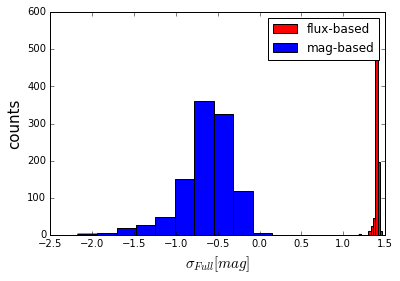

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
sf = flux2ab(varMetricsFull['sigmaFull'].values[varMetricsFull['sigmaFull'].values>0]*1e-27 )
sf_mag = varMetricsFull['sigmaFullMag'].values
fig,ax = plt.subplots()
ax.hist(np.log10(sf[sf>0]), label='flux-based', color='red')
ax.hist(np.log10(sf_mag[sf_mag>0]),label='mag-based', color='blue')
ax.set_title('')
ax.set_xlabel(r'$\sigma_{Full} [mag]$', fontsize=15)
ax.set_ylabel('counts', fontsize=15)
plt.legend()
plt.savefig('/astro/users/suberlak/S13Agg_analysis/data_products/sigma_experiment_sigma_full.png')

In [31]:
mask = varMetricsFull['avgMJD'] == varMetricsFull['avgMJD'].values[0]
varMetricsFull.index[mask]


Int64Index([216172782516437336, 216172782516437643, 216172782516438325,
            216172782516438456, 216172782516438466, 216172782516438605,
            216172782516438637, 216172782516438771, 216172782516439255,
            216172782516439734, 216172782516440932, 216172782516441144,
            216172782516441145, 216172782516441146, 216172782516441147,
            216172782516441290, 216172782516441291, 216172782516441525,
            216172782516441526, 216172782516441764, 216172782516441806,
            216172782516442050],
           dtype='int64', name=u'objectId')

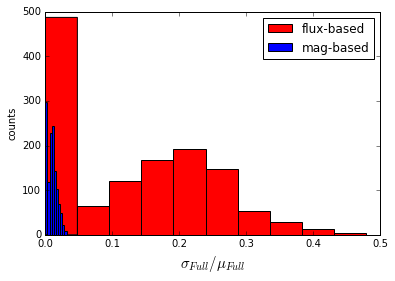

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
ratio_flux = varMetricsFull['sigmaFull'].values / varMetricsFull['muFull'].values
ratio_mag  = varMetricsFull['sigmaFullMag'].values / varMetricsFull['muFullMag'].values
mask= (ratio_flux < 0.5) & (ratio_mag < 0.5)

fig,ax = plt.subplots()
ax.hist(ratio_flux[mask], color='red', bins=10, label = 'flux-based')
ax.hist(ratio_mag[mask], color='blue',bins=10, label='mag-based')
ax.set_xlabel(r'$\sigma_{Full} / \mu_{Full}$', fontsize=15)
ax.set_ylabel('counts')
plt.legend()
plt.savefig('/astro/users/suberlak/S13Agg_analysis/data_products/sigma_experiment_ratio.png')

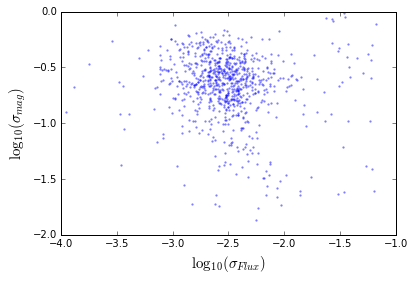

In [21]:
fig,ax = plt.subplots()
ax.scatter(np.log10(varMetricsFull['sigmaFull'].values), np.log10(varMetricsFull['sigmaFullMag'].values), marker='.', lw=0, alpha=0.5)
ax.set_xlim(-4,-1)
ax.set_ylim(-2,0)
ax.set_xlabel(r'$\log_{10}(\sigma_{Flux})$', fontsize=15)
ax.set_ylabel(r'$\log_{10}(\sigma_{mag})$', fontsize=15)
plt.savefig('/astro/users/suberlak/S13Agg_analysis/data_products/sigma_experiment_sig_sig.png')


In [30]:
varMetricsFull['muFull'].values

array([ 0.015061  ,  0.04332405,  0.00667265, ...,  0.00961628,
        0.004205  ,  0.04699655])